<a href="https://colab.research.google.com/github/martell-n-tardy/Risk-Prediction-Models-for-Type-2-Diabetes/blob/main/LightGBM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LightGBM Model: Predicting Type 2 Diabetes - By Martell Tardy, M.S.**

The goal of our binary classification problem is to create a machine learning model that makes a prediction in situations where the thing to predict can take one of just two possible values. For this study, we want to predict whether a person is diabetic(1) or not diabetic(2) based on the 24 predictor variables selected.

# Load packages

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean,std
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score,accuracy_score
!pip install shap
import shap

# Load data

In [2]:
#mount Drive and grant access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#read in data and save as variable df
df = pd.read_csv('/content/drive/MyDrive/SPRINGBOARD/CAPSTONE 3/BRFSS Data/Processed/finalfeats_2015.csv')
df

,state,prediabetes,age,weight,blood_pressure_meds,general_health,fruit_juice,pneumonia_shot,race,cholesterol_check,high_cholesterol,height,cognitive_decline,alcohol,fruit,kidney_health,physical_health,sex,shingles_vaccine,other_veg,green_veg,cigarettes,employment,sodium,type2_diabetes
0,0.169308,0.074352,0.171904,0.230504,0.266355,0.296992,0.112202,0.212869,0.119337,0.173159,0.225517,0.128326,0.111739,0.180150,0.128318,0.119388,0.214877,0.123972,0.124384,0.128453,0.127072,0.097530,0.292054,0.125268,0
1,0.169308,0.074352,0.113063,0.115439,0.053195,0.089652,0.112202,0.076920,0.119337,0.027878,0.083594,0.128326,0.264431,0.180150,0.128318,0.119388,0.094261,0.123972,0.124384,0.128453,0.127072,0.113719,0.134980,0.098757,0
2,0.169308,0.074352,0.218720,0.056077,0.053195,0.296992,0.122087,0.119395,0.119337,0.173159,0.225517,0.122700,0.111739,0.113072,0.123805,0.119388,0.214877,0.123972,0.124384,0.125341,0.123034,0.113719,0.200757,0.125268,0
3,0.169308,0.074352,0.171904,0.115439,0.266355,0.296992,0.153444,0.212869,0.119337,0.173159,0.225517,0.128326,0.264431,0.180150,0.128318,0.119388,0.277691,0.123972,0.124384,0.128453,0.127072,0.113719,0.292054,0.098757,0
4,0.169308,0.074352,0.171904,0.056077,0.053195,0.296992,0.122087,0.212869,0.119337,0.173159,0.083594,0.128326,0.164604,0.180150,0.128318,0.119388,0.256335,0.123972,0.124384,0.128453,0.127072,0.113719,0.292054,0.198241,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,0.201110,0.151725,0.218720,0.043446,0.266355,0.296992,0.112202,0.076920,0.140718,0.173159,0.225517,0.128326,0.164604,0.180150,0.147180,0.119388,0.094261,0.123972,0.124384,0.128453,0.175950,0.113719,0.200757,0.198241,1
441452,0.201110,0.151725,0.000033,0.115439,0.053195,0.089652,0.112202,0.076920,0.140718,0.173159,0.083594,0.128326,0.111739,0.180150,0.128318,0.119388,0.094261,0.123972,0.124384,0.128453,0.127072,0.113719,0.070031,0.198241,0
441453,0.201110,0.151725,0.218720,0.230504,0.266355,0.296992,0.122087,0.119395,0.140718,0.173159,0.225517,0.128326,0.111739,0.093876,0.123805,0.119388,0.094261,0.123972,0.124384,0.125341,0.123034,0.189050,0.200757,0.125268,0
441454,0.201110,0.151725,0.113063,0.056077,0.266355,0.089652,0.112202,0.076920,0.140718,0.173159,0.083594,0.122700,0.164604,0.180150,0.128318,0.119388,0.094261,0.134777,0.124384,0.128453,0.127072,0.113719,0.134980,0.198241,0


In [11]:
#read in data and save as categorical_dataframe
categ_df = pd.read_csv('/content/drive/MyDrive/SPRINGBOARD/CAPSTONE 3/BRFSS Data/Processed/featsnames_2015.csv')
categ_df

,state,prediabetes,age,weight,blood_pressure_meds,general_health,fruit_juice,pneumonia_shot,race,cholesterol_check,high_cholesterol,height,cognitive_decline,alcohol,fruit,kidney_health,physical_health,sex,shingles_vaccine,other_veg,green_veg,cigarettes,employment,sodium,type2_diabetes
0,Alabama,no,60-64,obese,yes,poor-health,1-500,yes,white,<1year,yes,61-70,refused,no,1-500,no,11-15,female,refused,1-500,1-100,1m>3months,unable-to-work,refused,0
1,Alabama,no,50-54,overweight,refused,good-health,1-500,no,white,>5years,no,61-70,yes,no,1-500,no,no,female,refused,1-500,1-100,refused,out-of-work>1year,no,0
2,Alabama,no,70-74,normal-weight,refused,poor-health,idk-refused,refused,white,<1year,yes,71-80,refused,idk-refused,idk-refused,no,11-15,female,refused,idk-refused,idk-refused,refused,retired,refused,0
3,Alabama,no,60-64,overweight,yes,poor-health,no,yes,white,<1year,yes,61-70,yes,no,1-500,no,26-30,female,refused,1-500,1-100,refused,unable-to-work,no,0
4,Alabama,no,60-64,normal-weight,refused,poor-health,idk-refused,yes,white,<1year,no,61-70,no,no,1-500,no,16-20,female,refused,1-500,1-100,refused,unable-to-work,yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,Puerto-Rico,refused,70-74,underweight,yes,poor-health,1-500,no,hispanic,<1year,yes,61-70,no,no,no,no,no,female,refused,1-500,no,refused,retired,yes,1
441452,Puerto-Rico,refused,25-29,overweight,refused,good-health,1-500,no,hispanic,<1year,no,61-70,refused,no,1-500,no,no,female,refused,1-500,1-100,refused,employed-for-wages,yes,0
441453,Puerto-Rico,refused,70-74,obese,yes,poor-health,idk-refused,refused,hispanic,<1year,yes,61-70,refused,1-25,idk-refused,no,no,female,refused,idk-refused,idk-refused,>10years,retired,refused,0
441454,Puerto-Rico,refused,50-54,normal-weight,yes,good-health,1-500,no,hispanic,<1year,no,71-80,no,no,1-500,no,no,male,refused,1-500,1-100,refused,out-of-work>1year,yes,0


# Preparing the data

## training a LightGBM model

From the last notebook we were able to confirm the following as the best parameters for our LightGBM binary classification model:


*   **n_estimators:** 500
*   **max_depth:** 9

*   **learning rate:** 0.1
*   **boosting type:** gbdt

Using these parameters from the hyperparameter tuning we can now build our LightGBM model, train it, and see our prediction of the test set. We will evaluate model performance using the roc_auc_score metric (AUC).

## training the model

In [4]:
#copy of df as appropriate type for LightGBM
df1 = df

#split data into X and y
X,y = df1.drop(['type2_diabetes'], axis = 1), df1['type2_diabetes']
#split data 70/30 train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
#define model
model = lgb.LGBMClassifier(n_estimators=500,learning_rate=0.1,boosting_type='gbdt',objective='binary',max_depth=9)

#train model
model_fit = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='auc')

[20]	training's binary_logloss: 0.243604	training's auc: 0.904675	valid_0's binary_logloss: 0.247895	valid_0's auc: 0.90106
[40]	training's binary_logloss: 0.22611	training's auc: 0.910558	valid_0's binary_logloss: 0.23104	valid_0's auc: 0.906575
[60]	training's binary_logloss: 0.220264	training's auc: 0.913348	valid_0's binary_logloss: 0.225816	valid_0's auc: 0.908882
[80]	training's binary_logloss: 0.217696	training's auc: 0.914988	valid_0's binary_logloss: 0.223893	valid_0's auc: 0.909923
[100]	training's binary_logloss: 0.215254	training's auc: 0.916572	valid_0's binary_logloss: 0.222145	valid_0's auc: 0.91087
[120]	training's binary_logloss: 0.21355	training's auc: 0.917798	valid_0's binary_logloss: 0.221108	valid_0's auc: 0.91143
[140]	training's binary_logloss: 0.212309	training's auc: 0.918762	valid_0's binary_logloss: 0.220685	valid_0's auc: 0.91157
[160]	training's binary_logloss: 0.211366	training's auc: 0.919653	valid_0's binary_logloss: 0.220572	valid_0's auc: 0.911592
[18

Now, let's check for overfitting since this can be an issue with LightGBM and then examine the classification report of the model's prediction.

## evaluating model predictions

In [6]:
print('Training accuracy {:.4f}'.format(model_fit.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model_fit.score(X_test,y_test)))

Training accuracy 0.9157
Testing accuracy 0.9073


In [7]:
print(metrics.classification_report(y_test,model_fit.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95    115306
           1       0.77      0.40      0.53     17131

    accuracy                           0.91    132437
   macro avg       0.85      0.69      0.74    132437
weighted avg       0.90      0.91      0.89    132437



As we can clearly see, there is absolutely no significant difference between both the accuracies for the test and training sets and hence the model has made an estimation that is quite accurate and not flawed with overfitting. We can see from the classification report that the model is struggling to predict class 1, but not class 0. This probably due to imbalance within the training set, which is confirmed in the imbalanced support output. **Overall, the model has out peformed the baseline model(90.8%) at an accuracy of 91.5%.**

Now, let's examine the feature importance as predicted by this model.

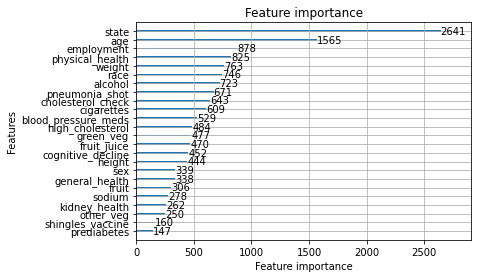

In [8]:
lgb.plot_importance(model_fit)

From the output we can see that the top three most important features are `state`, `age` and `employment`. Although, we can now see which features are deemed most important, we aren't sure why. The problem with global importance is that it gives an average overview of variable contributing to the model but it lacks the direction of impact means whether a variable has a positive or negative influence. This is because the LightGBM is a blackbox model and therefore, it is nearly impossible to get a feeling for its inner functioning. To address this we will utilize the advance algorithm SHAP to understand the variable importance along with their direction of impact.

# Applying SHAP 

## summary plot

To understand exactly what is occuring within our trained LightGBM classification model we will examine a summary plot created through the SHAP python library. This plot’s x-axis illustrates the SHAP values (-ve to +ve) and the y-axis indicates the features (variables). When plotting, we call shap_values [1], because it is a classification problem, otherwise there is a separate array of SHAP values for each possible outcome. To avoid this we index [1] to get the SHAP values for the prediction of "True". The color bar indicates the impact. Red color indicates high feature impact and blue color indicates low feature impact.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


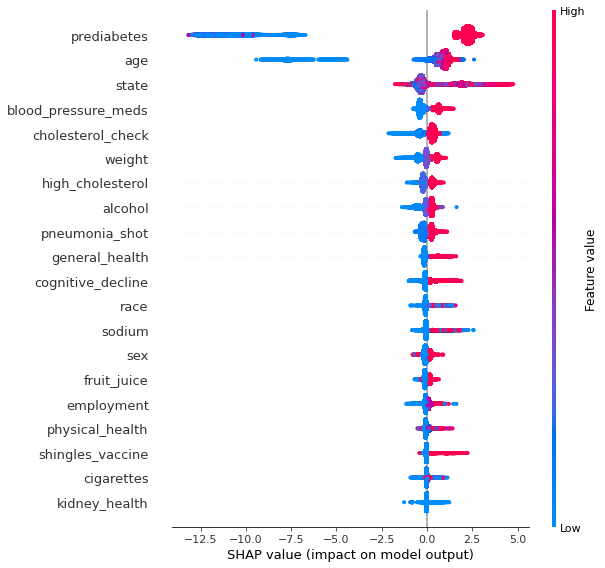

In [9]:
#create tree explainer
ex = shap.TreeExplainer(model_fit)
#estimate shaply values on test dataset
shap_values = ex.shap_values(X_test)
#generate a summary plot
shap.summary_plot(shap_values[1], X_test) 

In [ ]:
#create tree explainer
ex = shap.TreeExplainer(model_fit)
#estimate shaply values on test dataset
shap_values = ex.shap_values(X_test)
#generate a summary plot
shap.summary_plot(shap_values, X_test) 

The summary plot shows the top five influential variables are the `prediabetes`, `age`, `state`, `blood_pressure_meds`, and `cholestrol_check` for participants which determines the likelihood of a participant being type 2 diabetic. 

The `prediabetes` variable shows "never having prediabetes" = blue, has a negative impact(or relationship) with the target variable `type2_diabetes`. Vice versa, "having/had prediabetes" = red, has a positive impact on the target variable. Therefore, we can conclude that a leading indicator for if a participant has type 2 diabetes is that he/she has or has had prediabetes. 

The `age` variable has a negative impact on the target variable. It appears that the lower value observations (blue) for the feature `age` have a negative impact on the target feature, but as `age` increases it becomes a positive impact. Therefore, as the age of a participant increases so does the likelihood of that participant having type2 diabetes.

The `state` variable has a positive impact on the target variable, however, this will need to be explored through a partial dependence plot to truly understand which of the observations in this feature are having the strongest impact.

The `blood_pressure_meds` variable has a positive impact on the target variable. The plot shows that if a participant takes blood pressure medication (red) they are more likely to have type 2 diabetes.

The `cholestrol_check` variable has a negative impact on the target variable. This could be because the range of values observed for this feature are mostly ordinal but also contain two categorical values equivalent to the value of no. Therefore, most likely the lower values for this feature have a negative impact and as the values increase, referring to the time that has passed since your last cholestrol check, those at the longest time duration would have a positive impact. However, those participants who answered "don't know" or "refused to answer" would be seen as "no" observations and therefore, have a low impact. This will be examined further through a partial dependence plot.

## dependence plot

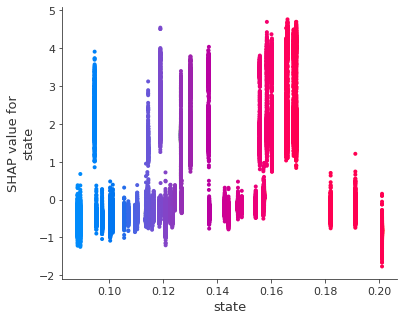

In [20]:
#examine state observations and their impact
shap.dependence_plot('state', shap_values[1], X_test, interaction_index = 'state')

Will revise variable in Feature Engineering notebook as regions, to better understand data.

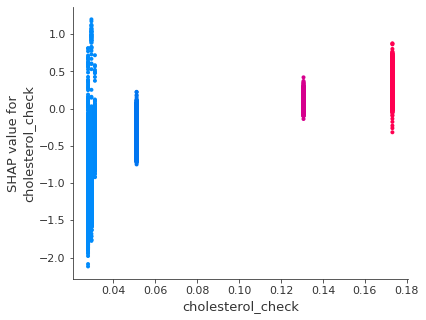

In [19]:
#examine cholestrol_check obsrvations and their impact
shap.dependence_plot('cholesterol_check', shap_values[1], X_test, interaction_index = 'cholesterol_check')

In [13]:
df['cholesterol_check'].value_counts()

0.173159    293355
0.031165     59426
0.051060     43596
0.029493     25972
0.027878     13523
0.130731      5584
Name: cholesterol_check, dtype: int64

In [14]:
categ_df['cholesterol_check'].value_counts()

<1year      293355
refused      59426
1>2years     43596
2>5years     25972
>5years      13523
idk           5584
Name: cholesterol_check, dtype: int64

The value 0.13 refers to participants who answered "don't know" and the value 0.17 refers to participants who answered "less than one year". It appears participants who've gotten their cholestrol checked "within the last year" and those who answered "don't know" are more likely to be diagnosed with type 2 diabetes. All the other participant responses actually highly unlikely to be diagnosed with type 2 diabetes. 

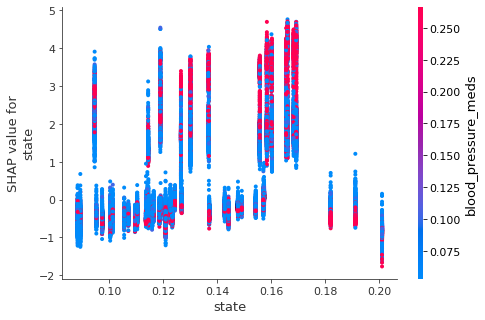

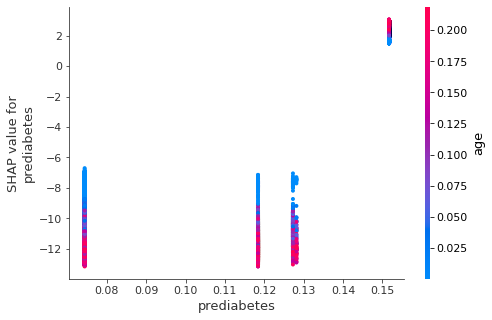

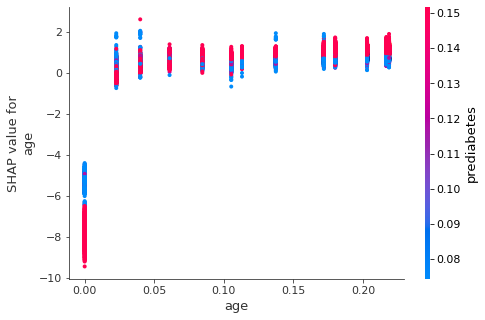

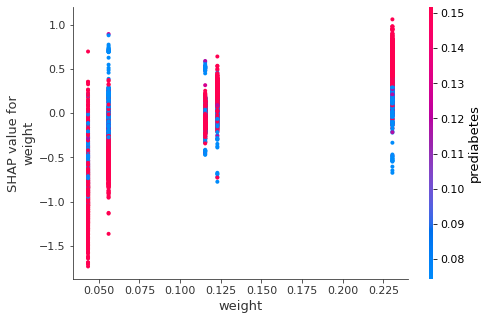

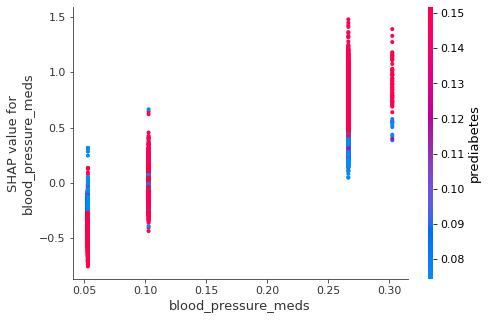

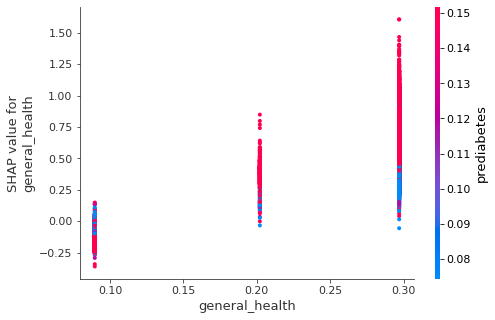

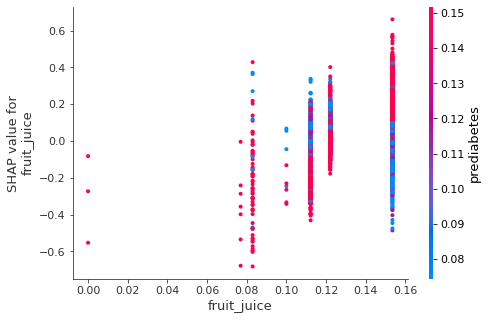

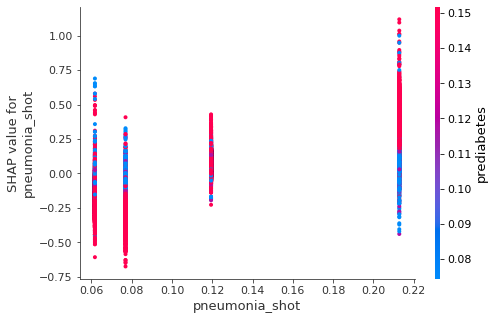

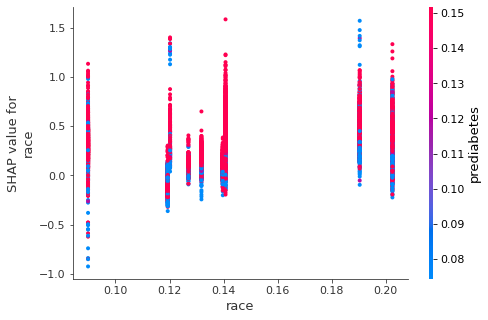

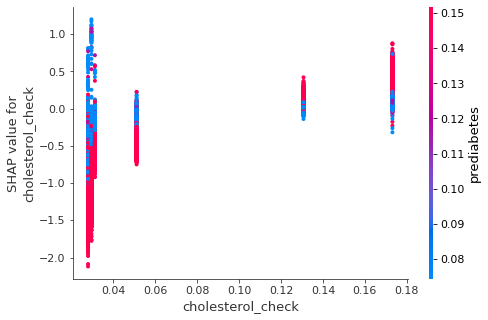

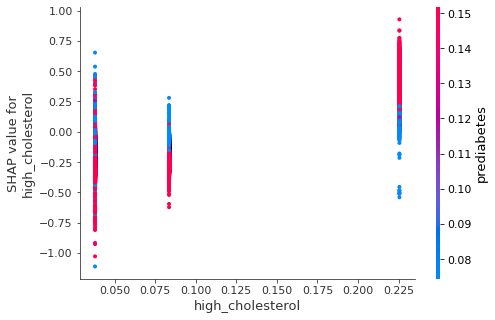

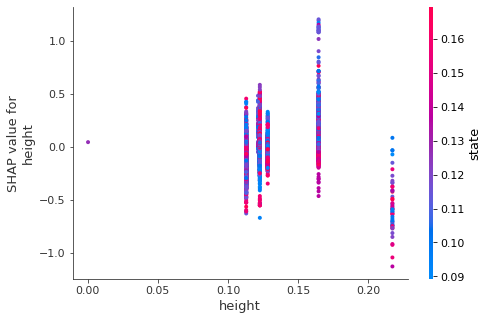

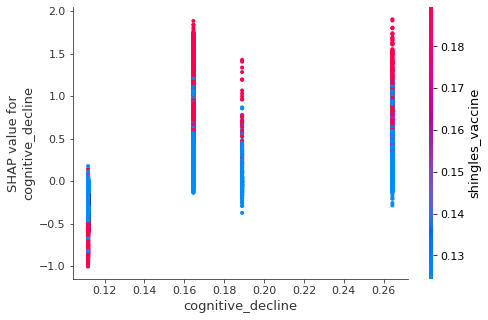

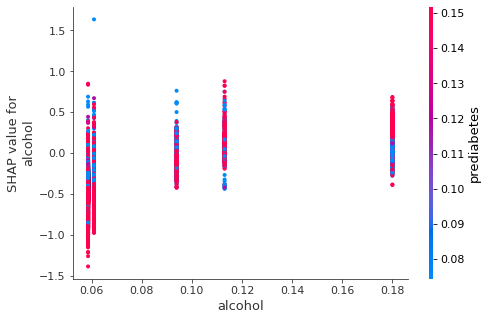

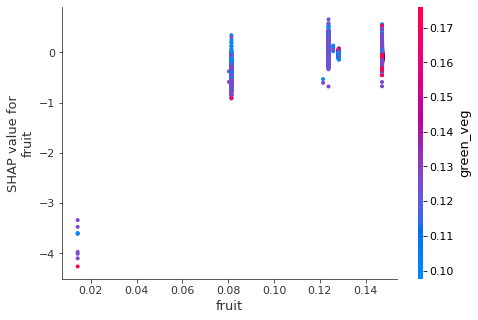

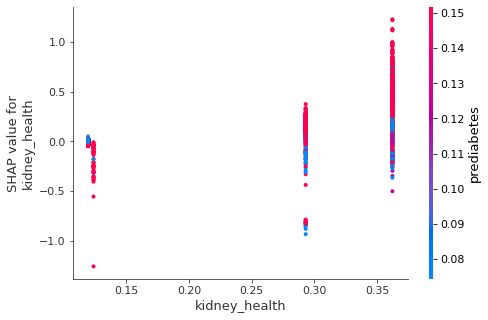

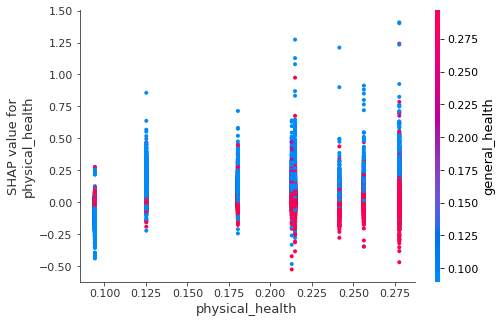

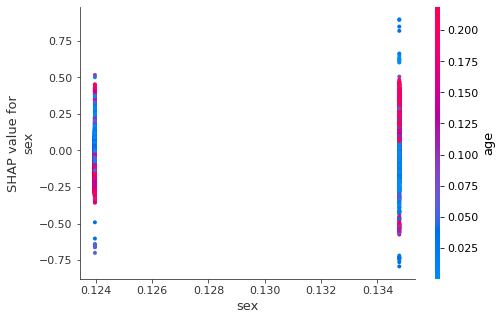

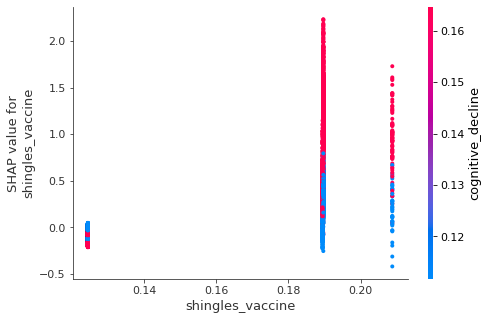

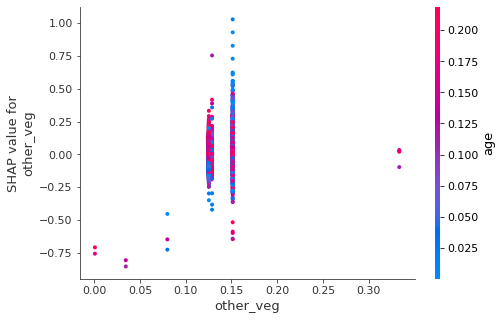

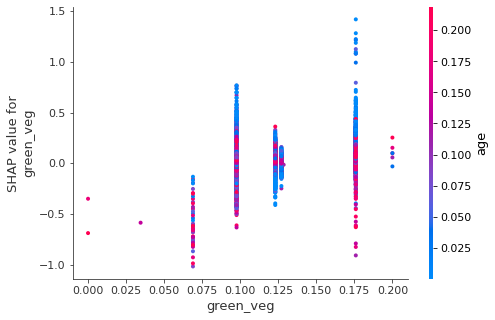

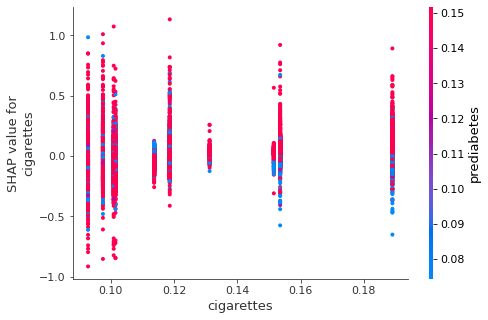

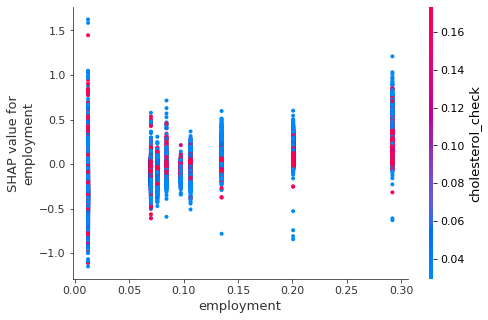

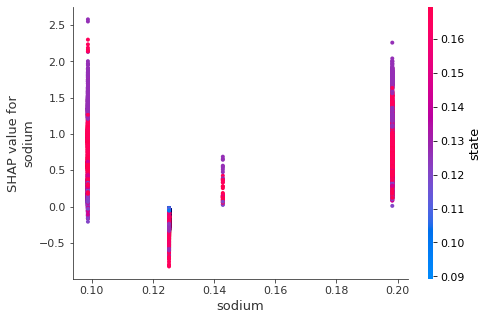

In [16]:
#examine potentially interesting feature relationships
for name in X_train.columns:
  shap.dependence_plot(name, shap_values[1], X_test)

# Summary

After building our model using the best performing parameters we have an accuracy score of 91.5% and a precision accuracy of 92% for those who are not type 2 diabetic and 77% for those who are. We have also confirmed the 5 leading characteristics of someone having type 2 diabetes are related to prediabetes, age, state, blood pressure medication and cholestrol checks. Specifically, we can conclude that if a participant has prediabetes or has had prediabetes before this is the leading indicator for a type 2 diabetes diagnosis. As the age of a participant increases so does the likelihood of that participant having a type 2 diabetes diagnosis. If a participant takes blood pressure medication they are more likely to have a type 2 diabetes diagnosis. Lastly, participants who got their cholestrol checked "within the last year" and those who answered "don't know" are more likely to be diagnosed with type 2 diabetes.